<a href="https://colab.research.google.com/github/EikEUFS/AprendizadoDeMaquina/blob/main/AM_Tarefa_03B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resultados
O dataset do livro possui 120 classes de cachorros, porém o arquivo baixado completo, posusi 133 classes, então a versão do dataset está diferente.

O livro conseguiu obter o train loss 2.241 enquanto que o treino com a rede densa densenet201 obteve o train loss de 4.758.

In [ ]:
!pip install d2l==0.16.4

In [ ]:
import os
import re
import zipfile

import matplotlib.pyplot as plt

import torch as torch
import torch.nn as torchNn
import torch.nn.functional as torchNnF
import torch.optim as torchO
import torch.utils as torchU
import torch.utils.data as torchUD
import torch.utils.data.dataloader as torchUDD

import torchvision as torchvision
import torchvision.transforms as torchvisionT
import torchvision.utils as torchvisionU
import torchvision.datasets as torchvisionD
import torchvision.datasets.utils as torchvisionDU
import torchvision.models as torchvisionM

from d2l import torch as d2l
from __future__ import division, absolute_import
from collections import OrderedDict

import gc

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import google.colab as colab

In [ ]:
# Download do arquivo para treino, validação e teste
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2021-05-20 01:01:21--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.216
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.3’

dogImages.zip.3     100%[===================>]   1.05G  41.8MB/s    in 26s     

2021-05-20 01:01:47 (40.8 MB/s) - ‘dogImages.zip.3’ saved [1132023110/1132023110]



In [ ]:
# Extrair o arquivo baixado
with zipfile.ZipFile('./dogImages.zip', 'r') as zip:
  zip.extractall()

In [ ]:
data_dir = './dogImages'

# Listar as classes do arquivo
print(os.listdir(data_dir))
print()
classes= os.listdir(data_dir + '/train')
print(classes)

['train', 'test', 'valid']

['090.Italian_greyhound', '033.Bouvier_des_flandres', '118.Pembroke_welsh_corgi', '048.Chihuahua', '012.Australian_shepherd', '111.Norwich_terrier', '016.Beagle', '002.Afghan_hound', '072.German_shorthaired_pointer', '074.Giant_schnauzer', '099.Lhasa_apso', '113.Old_english_sheepdog', '001.Affenpinscher', '133.Yorkshire_terrier', '043.Canaan_dog', '014.Basenji', '022.Belgian_tervuren', '103.Mastiff', '089.Irish_wolfhound', '083.Ibizan_hound', '008.American_staffordshire_terrier', '094.Komondor', '010.Anatolian_shepherd_dog', '029.Border_collie', '129.Tibetan_mastiff', '049.Chinese_crested', '086.Irish_setter', '108.Norwegian_buhund', '088.Irish_water_spaniel', '053.Cocker_spaniel', '091.Japanese_chin', '024.Bichon_frise', '039.Bull_terrier', '097.Lakeland_terrier', '114.Otterhound', '034.Boxer', '095.Kuvasz', '117.Pekingese', '100.Lowchen', '115.Papillon', '005.Alaskan_malamute', '003.Airedale_terrier', '026.Black_russian_terrier', '069.French_bulldog', '077

In [ ]:
transform_train = torchvisionT.Compose([
    torchvisionT.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvisionT.RandomHorizontalFlip(),
    torchvisionT.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    torchvisionT.ToTensor(),
    torchvisionT.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

transform_test = torchvisionT.Compose([
    torchvisionT.Resize(256),
    torchvisionT.CenterCrop(224),
    torchvisionT.ToTensor(),
    torchvisionT.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

In [ ]:
train_ds = torchvisionD.ImageFolder(data_dir + '/train', transform=transform_train)

valid_ds = torchvisionD.ImageFolder(data_dir + '/valid', transform=transform_test)

test_ds = torchvisionD.ImageFolder(data_dir + '/test', transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  001.Affenpinscher (0)


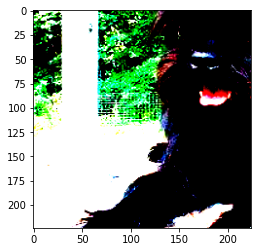

In [ ]:
# Teste para ver se mostra imagem
def show_image(img,label):
    print('Label: ', train_ds.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
    
show_image(train_ds[0][0], train_ds[0][1])

In [ ]:
# Cria dois Loaders um com batch 4 e outro com batch 128
batch_size_1 = 4
batch_size_2 = 128

train_dl_1 = torchUDD.DataLoader(train_ds, batch_size_1, shuffle=True, num_workers=4, pin_memory=True )
valid_dl_1 = torchUDD.DataLoader(valid_ds, batch_size_1, num_workers=4, pin_memory=True)

train_dl_2 = torchUDD.DataLoader(train_ds, batch_size_2, shuffle=True, num_workers=4, pin_memory=True )
valid_dl_2 = torchUDD.DataLoader(valid_ds, batch_size_2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


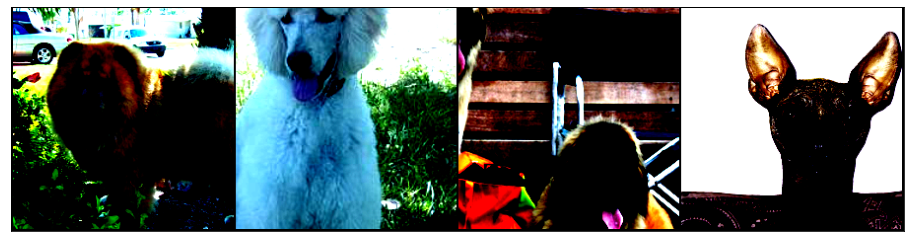

In [ ]:
# Visualiza o batch de um loader
def show_images_batch(d1):
  for images, labels in d1:
      fig, ax= plt.subplots(figsize=(16,8))
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(torchvisionU.make_grid(images, nrow=16).permute(1,2,0))
      break
        
show_images_batch(train_dl_1)

In [ ]:
# Modelos que vão ser comparados (DenseNet201 e DenseNet161)
__all__ = ['densenet201', 'densenet161']

model_urls = {
    'densenet201':
    'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161':
    'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

# Modelo da camada densa
class _DenseLayer(torchNn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', torchNn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', torchNn.ReLU(inplace=True)),
        self.add_module('conv1', torchNn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', torchNn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', torchNn.ReLU(inplace=True)),
        self.add_module('conv2', torchNn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

# Modulo que conecta todas as camadas
class _DenseBlock(torchNn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i*growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i+1), layer)

# Modulo que realiza operação entre uma camada e outra
class _Transition(torchNn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', torchNn.BatchNorm2d(num_input_features))
        self.add_module('relu', torchNn.ReLU(inplace=True))
        self.add_module('conv', torchNn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', torchNn.AvgPool2d(kernel_size=2, stride=2))

# Rede Convolucional Densa
class DenseNet(torchNn.Module):
    def __init__(self, num_classes, loss, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, fc_dims=None, dropout_p=None, **kwargs):
        super(DenseNet, self).__init__()
        self.loss = loss

        # Primeira convolução
        self.features = torchNn.Sequential(OrderedDict([
                    ('conv0', torchNn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ('norm0', torchNn.BatchNorm2d(num_init_features)),
                    ('relu0', torchNn.ReLU(inplace=True)),
                    ('pool0', torchNn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]))

        # Modulo DenseBlock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i+1), block)
            num_features = num_features + num_layers*growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i+1), trans)
                num_features = num_features // 2

        #Camada Normalização
        self.features.add_module('norm5', torchNn.BatchNorm2d(num_features))

        self.global_avgpool = torchNn.AdaptiveAvgPool2d(1)
        self.feature_dim = num_features
        self.fc = self._construct_fc_layer(fc_dims, num_features, dropout_p)

        # Camada Linear
        self.classifier = torchNn.Linear(self.feature_dim, num_classes)

        self._init_params()

    # Camada full conectada
    def _construct_fc_layer(self, fc_dims, input_dim, dropout_p=None):
        if fc_dims is None:
            self.feature_dim = input_dim
            return None

        assert isinstance(fc_dims, (list, tuple)), 'fc_dims must be either list or tuple, but got {}'.format(type(fc_dims))

        layers = []
        for dim in fc_dims:
            layers.append(torchNn.Linear(input_dim, dim))
            layers.append(torchNn.BatchNorm1d(dim))
            layers.append(torchNn.ReLU(inplace=True))
            if dropout_p is not None:
                layers.append(torchNn.Dropout(p=dropout_p))
            input_dim = dim

        self.feature_dim = fc_dims[-1]

        return torchNn.Sequential(*layers)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, torchNn.Conv2d):
                torchNn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torchNn.init.constant_(m.bias, 0)
            elif isinstance(m, torchNn.BatchNorm2d):
                torchNn.init.constant_(m.weight, 1)
                torchNn.init.constant_(m.bias, 0)
            elif isinstance(m, torchNn.BatchNorm1d):
                torchNn.init.constant_(m.weight, 1)
                torchNn.init.constant_(m.bias, 0)
            elif isinstance(m, torchNn.Linear):
                torchNn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    torchNn.init.constant_(m.bias, 0)

    def forward(self, x):
        f = self.features(x)
        f = F.relu(f, inplace=True)
        v = self.global_avgpool(f)
        v = v.view(v.size(0), -1)

        if self.fc is not None:
            v = self.fc(v)

        if not self.training:
            return v

        y = self.classifier(v)

        if self.loss == 'softmax':
            return y
        elif self.loss == 'triplet':
            return y, v
        else:
            raise KeyError('Unsupported loss: {}'.format(self.loss))

def init_pretrained_weights(model, model_url):
    pretrain_dict = model_zoo.load_url(model_url)

    pattern = re.compile(r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
    for key in list(pretrain_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            pretrain_dict[new_key] = pretrain_dict[key]
            del pretrain_dict[key]

    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)

"""
densenet201: num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32)
"""
def densenet201(num_classes, loss='softmax', pretrained=True, **kwargs):
    model = DenseNet(num_classes=num_classes, loss=loss, num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32), fc_dims=None, dropout_p=None, **kwargs)
    if pretrained:
        init_pretrained_weights(model, model_urls['densenet201'])
    return model

"""
densenet161: num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24)
"""
def densenet161(num_classes, loss='softmax', pretrained=True, **kwargs):
    model = DenseNet(num_classes=num_classes, loss=loss, num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24), fc_dims=None, dropout_p=None, **kwargs)
    if pretrained:
        init_pretrained_weights(model, model_urls['densenet161'])
    return model

In [ ]:
loss = torchNn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum / n

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    net = torchNn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torchO.SGD((param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torchO.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'valid loss'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            torch.cuda.empty_cache()
            gc.collect()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
        scheduler.step()
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, 'f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(devices)}')

In [ ]:
devices = d2l.try_all_gpus()
num_epochs_1 = 5
num_epochs_2 = 100
lr = 0.001
wd = 1e-4
lr_period = 10
lr_decay = 0.1

In [ ]:
model_1 = densenet201(133, pretrained=False)
model_2 = densenet201(133, pretrained=False)

In [ ]:
if torch.cuda.is_available():
    model_1.to('cuda')
    model_2.to('cuda')

train loss 4.758, valid loss 0.020
32.1 examples/sec on [device(type='cuda', index=0)]


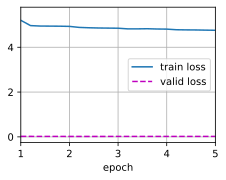

In [ ]:
train(model_1, train_dl_1, valid_dl_1, num_epochs_1, lr, wd, devices, lr_period, lr_decay)